In [16]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

pd.set_option('display.max_columns', 300)

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import re
import string

import scipy
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
from tqdm import tqdm
tqdm.pandas()

/Users/alecmccabe/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [18]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [19]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [20]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http",
              "https","char","reuters","wall","street","journal","photo","\n","vice","news","like","time","make"]

In [21]:
domain_extensions = ['.com/','.org/','.net/','.co.uk/']

def url_subpages(url):
    for extension in domain_extensions:
        try:
            if extension in url:
                re_test = re.search(extension,url)
                start_pos = re_test.start()+len(extension)
                cut = url[start_pos:]

                re_test2 = re.search('/',cut)
                end_pos = re_test2.start()
                cut2 = cut[0:end_pos]

                return cut2
            else:
                pass
        except:
            return "no clear section"


In [22]:
def black_txt(token):
    return  token not in stopwords and token not in list(string.punctuation)  and len(token)>3

def clean_txt(text, string = True):
    clean_text = []
    clean_text2 = []
    text = text.lower()
    text = re.sub("'", "",text)
    text = re.sub("\n", "",text)
    text = re.sub("(\\d|\\W)+"," ",text)
    text = re.sub('time magazine','',text)
    text = re.sub('breitbart','',text)
    text = re.sub('click','',text)
    
    clean_text = [ lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(text) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    
    if string == True:
        return " ".join(clean_text2)
    else:
        return clean_text2

# Read and Clean

In [23]:
#load in data
data = pd.read_csv('initial_data2.csv', index_col = 0)
data.reset_index(drop=True, inplace=True)
data = data.drop_duplicates('url', keep = 'first')
data.drop(['urlToImage'],axis=1,inplace=True)

In [24]:
conditions = [
    (data['content'].isna())
]

choices = [
    (data['description'])
]

data['content'] = np.select(conditions, choices, data['content'])

In [25]:
#drop where description is isna()
to_drop = data[data['description'].isna()].index
data.drop(to_drop, inplace=True)

#drop where title is isna()
to_drop = data[data['title'].isna()].index
data.drop(to_drop, inplace=True)

#drop where target is isna()
to_drop = data[data['target'].isna()].index
data.drop(to_drop, inplace=True)

#drop where publishedAt is isna()
to_drop = data[data['publishedAt'].isna()].index
data.drop(to_drop, inplace=True)

#drop where month is isna()
to_drop = data[data['month'].isna()].index
data.drop(to_drop, inplace=True)

#drop where content is isna()
to_drop = data[data['content'].isna()].index
data.drop(to_drop, inplace=True)

#drop where url is isna()
to_drop = data[data['url'].isna()].index
data.drop(to_drop, inplace=True)

In [26]:
conditions = [
    (data['author'].isna())
]

choices = [
    ('unknown')
]

data['author'] = np.select(conditions, choices, data['author'])

In [27]:
data.drop(['description'],axis=1,inplace=True)

In [28]:
data=data.dropna()

In [29]:
to_drop = data[data['full_text']=='401 Error'].index
data.drop(to_drop, inplace=True)

In [30]:
data['url_subpages'] = data['url'].apply(url_subpages)

In [31]:
data.url_subpages.value_counts().head(10)

news                10365
no clear section     6805
article              3982
2020                 3125
politics             2140
en_us                2137
homenews             2019
video                1507
intelligencer        1247
Politics             1151
Name: url_subpages, dtype: int64

In [32]:
data['predictor'] = data['title'] + ' ' + data['full_text']

In [33]:
data['pred_len'] = data['predictor'].progress_apply(len)
data = data[data['pred_len']<8000]

100%|██████████| 49274/49274 [00:00<00:00, 488760.98it/s]


# Feature Engineering

**Text Stats**

In [117]:
blob = TextBlob((data.predictor[1]))

In [118]:
import textacy

In [119]:
def get_basic_stat(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    basic_stats = {'n_chars': ts.n_chars,
                   'n_long_words':ts.n_long_words ,
                   'n_monosyllable_words': ts.n_monosyllable_words,
                   'n_polysyllable_words': ts.n_polysyllable_words,
                   'n_sents': ts.n_sents,
                   'n_syllables': ts.n_syllables,
                   'n_unique_words': ts.n_unique_words,
                   'n_words': ts.n_words}
    return  basic_stats

In [120]:
tqdm.pandas()
data['Stats'] = data['predictor'].progress_apply(get_basic_stat)

100%|██████████| 45245/45245 [50:09<00:00, 15.03it/s]  


In [121]:
data['n_words'] = data['Stats'].apply(lambda x: x['n_words'])

data['n_long_words'] = data['Stats'].apply(lambda x: x['n_long_words'] / x['n_words'])

data['n_monosyllable_words'] = data['Stats'].apply(lambda x: x['n_monosyllable_words'] / x['n_words'])

data['n_polysyllable_words'] = data['Stats'].apply(lambda x: x['n_polysyllable_words'] / x['n_words'])

data['n_unique_words'] = data['Stats'].apply(lambda x: x['n_unique_words'] / x['n_words'])

In [122]:
def get_n_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    return ts.n_words


In [123]:
def get_n_long_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    n_words = ts.n_words
    
    return ts.n_long_words / n_words

In [124]:
def get_n_monosyllable_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    n_words = ts.n_words
    
    return ts.n_monosyllable_words / n_words

In [125]:
def get_n_polysyllable_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    n_words = ts.n_words
    
    return ts.n_polysyllable_words / n_words

In [126]:
def get_n_unique_words(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    n_words = ts.n_words
    
    return ts.n_unique_words / n_words

In [127]:
data = data[data['n_words']>125]

In [128]:
data.target.value_counts()

left         14928
center        8511
far_left      4920
far_right     3179
right         2285
Name: target, dtype: int64

**Textblob and sentiment**

In [129]:
def polarity_txt(text):
    return TextBlob(text).sentiment[0]

In [130]:
def subj_txt(text):
    return  TextBlob(text).sentiment[1]

In [131]:
data['polarity'] = data['predictor'].progress_apply(polarity_txt)
data.head(2)

100%|██████████| 33823/33823 [01:51<00:00, 304.61it/s]


,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,pred_len,Stats,n_words,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity
2,buzzfeed,"[{""@type"":""Person"",""name"":""Hannah Ryan"",""url"":...",Activists Are Using Negative Online Reviews To...,https://www.buzzfeed.com/hannahryan/coronaviru...,2020-04-30 23:20:48+00:00,Abdulla Moradi is one of about 120 people deta...,far_left,4.0,Hotel chains whose facilities have been used f...,hannahryan,Activists Are Using Negative Online Reviews To...,1690,"{'n_chars': 1386, 'n_long_words': 79, 'n_monos...",269,0.293680,0.609665,0.118959,0.572491,0.015668
3,buzzfeed,"[{""@type"":""Person"",""name"":""Gina Rushton"",""url""...","If You’re About To Start Full-Time Work, The C...",https://www.buzzfeed.com/ginarushton/coronavir...,2020-04-29 20:06:42+00:00,Young Australians starting their first job in ...,far_left,4.0,Young Australians starting their first job in ...,ginarushton,"If You’re About To Start Full-Time Work, The C...",2434,"{'n_chars': 1938, 'n_long_words': 79, 'n_monos...",431,0.183295,0.735499,0.085847,0.531323,-0.020759


In [132]:
data['subjectivity'] = data['predictor'].progress_apply(subj_txt)
data.head(2)

100%|██████████| 33823/33823 [01:45<00:00, 320.61it/s]


,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,pred_len,Stats,n_words,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity,subjectivity
2,buzzfeed,"[{""@type"":""Person"",""name"":""Hannah Ryan"",""url"":...",Activists Are Using Negative Online Reviews To...,https://www.buzzfeed.com/hannahryan/coronaviru...,2020-04-30 23:20:48+00:00,Abdulla Moradi is one of about 120 people deta...,far_left,4.0,Hotel chains whose facilities have been used f...,hannahryan,Activists Are Using Negative Online Reviews To...,1690,"{'n_chars': 1386, 'n_long_words': 79, 'n_monos...",269,0.293680,0.609665,0.118959,0.572491,0.015668,0.355131
3,buzzfeed,"[{""@type"":""Person"",""name"":""Gina Rushton"",""url""...","If You’re About To Start Full-Time Work, The C...",https://www.buzzfeed.com/ginarushton/coronavir...,2020-04-29 20:06:42+00:00,Young Australians starting their first job in ...,far_left,4.0,Young Australians starting their first job in ...,ginarushton,"If You’re About To Start Full-Time Work, The C...",2434,"{'n_chars': 1938, 'n_long_words': 79, 'n_monos...",431,0.183295,0.735499,0.085847,0.531323,-0.020759,0.294318


**Readability Indexes**

In [133]:
def mean_characters_per(text, group_size):
    #mean word length per X words
    averages = []
    
    text_split = text.split(" ")
    length = len(text_split)
    i = 0
    
    while i < length:
        values = []
        for word in text_split[i:i+group_size]:
            values.append(len(word))
        if len(values)==group_size:
            averages.append(sum(values)/len(values))
        else:
            pass
        i = i + group_size
    

    return sum(averages)/len(averages)

        

In [134]:
def mean_sentences_per(text, group_size):
    #mean sentences per X words
    sentences = []
    text_split = text.split(" ")
    length = len(text_split)

    i = 0

    while i < length:
        values = []
        for word in text_split[i:i+group_size]:
            values.append(word)

        sentence_counter = 0
        for word in values:
            if '.' in word:
                sentence_counter += 1
        sentences.append(sentence_counter)
        i = i + group_size

    return sum(sentences)/len(sentences)

In [135]:
# Coleman-Liau Index
# mccphw: mean character count per hundred words
# mscphw: mean sentence count per hundred words
def cli(text, group_size):
    mccphw = mean_characters_per(text, group_size)
    mscphw = mean_sentences_per(text, group_size)
    
    return (0.0588 * mccphw) - (0.296 * mscphw) - 15.8

In [136]:
data['mccphw'] = data['predictor'].progress_apply(lambda x: mean_characters_per(x,50))
data['mscphw'] = data['predictor'].progress_apply(lambda x: mean_sentences_per(x,50))
data['coleman_index'] = data['predictor'].progress_apply(lambda x: cli(x,50))

100%|██████████| 33823/33823 [00:06<00:00, 5243.59it/s]


**Profanity Index**

In [137]:
def check_profanity(comment):
    profane = pd.read_csv("profane_words.csv", header=None)
    profane = list(profane.loc[:,0])
    count = 0
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    for word in tokens:
        if word in profane:
            count += 1
    return count/len(tokens)

In [138]:
data['profanity'] = data['predictor'].progress_apply(check_profanity)

100%|██████████| 33823/33823 [08:56<00:00, 63.06it/s] 


# Visualizing Class Imbalance

In [139]:
import seaborn as sns

In [140]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

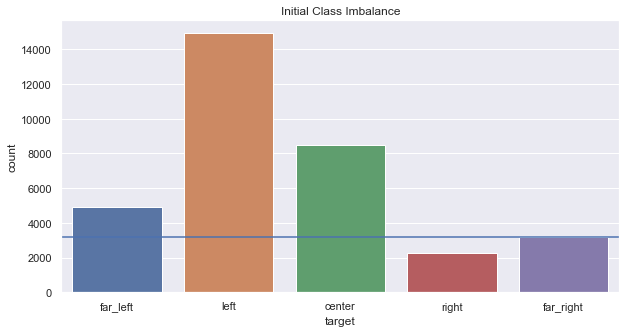

In [141]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='target', data=data)
ax.axhline(3179)
ax.set_title('Initial Class Imbalance')
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/class_imbalance.png')


In order to avoid oversampling any one class too much, I'm choosing to upsample right to far_right, and everything else I will downsample to far_right

# Test Dummy

In [142]:
#Dummy Classifier
from sklearn.dummy import DummyClassifier
X = data['predictor']
y = data['target']

dummy_cf = DummyClassifier(strategy='stratified')
dummy_cf.fit(X,y)
y_preds = dummy_cf.predict(X)

accuracy = dummy_cf.score(X,y)


In [143]:
results = pd.DataFrame(columns = ['model','accuracy'])
new_row = {'model': 'Dummy', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291399


# Resample

In [144]:
from sklearn.utils import resample
far_right = data[data.target == 'far_right'] #resample target
right = data[data.target == 'right'] #upsample
center = data[data.target == 'center'] #downsample
left = data[data.target =='left'] #downsample
far_left = data[data.target == 'far_left'] #downsample

right_upsampled = resample(right,
                          replace=True, # sample with replacement
                          n_samples=len(far_right), # match number in target class
                          random_state=42) 

center_downsampled = resample(center,
                          replace=True, # sample with replacement
                          n_samples=len(far_right), # match number in target class
                          random_state=42) 

left_downsampled = resample(left,
                          replace=True, # sample with replacement
                          n_samples=len(far_right), # match number in target class
                          random_state=42) 

far_left_downsampled = resample(far_left,
                          replace=True, # sample with replacement
                          n_samples=len(far_right), # match number in target class
                          random_state=42) 

data = pd.concat([far_right, right_upsampled, center_downsampled,left_downsampled,far_left_downsampled])
data.target.value_counts()

far_right    3179
left         3179
far_left     3179
right        3179
center       3179
Name: target, dtype: int64

In [145]:
data.reset_index(drop=True,inplace=True)

# Topic Modeling with LDA

In [146]:
import gensim

In [147]:
lda_far_right = data[data['target']=='far_right']['predictor']
lda_right = data[data['target']=='right']['predictor']
lda_center = data[data['target']=='right']['predictor']
lda_left = data[data['target']=='right']['predictor']
lda_far_left = data[data['target']=='far_left']['predictor']
all_sides = data['predictor']

In [148]:
all_token = all_sides.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(all_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in all_token]

all_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

all_lda.show_topics(formatted=True)

100%|██████████| 15895/15895 [01:31<00:00, 172.88it/s]


[(0,
  '0.033*"test" + 0.016*"positive" + 0.016*"coronavirus" + 0.011*"covid" + 0.010*"trump" + 0.009*"president" + 0.008*"house" + 0.008*"mask" + 0.007*"virus" + 0.007*"white"'),
 (1,
  '0.010*"coronavirus" + 0.007*"would" + 0.007*"house" + 0.006*"pandemic" + 0.006*"percent" + 0.005*"economic" + 0.005*"senate" + 0.005*"bill" + 0.005*"state" + 0.005*"fund"'),
 (2,
  '0.037*"trump" + 0.017*"president" + 0.010*"biden" + 0.009*"coronavirus" + 0.006*"campaign" + 0.006*"people" + 0.005*"white" + 0.005*"would" + 0.005*"house" + 0.005*"state"'),
 (3,
  '0.011*"company" + 0.010*"workers" + 0.009*"vote" + 0.007*"work" + 0.007*"mail" + 0.006*"ballot" + 0.006*"state" + 0.006*"also" + 0.006*"election" + 0.005*"employees"'),
 (4,
  '0.019*"coronavirus" + 0.012*"covid" + 0.010*"health" + 0.010*"vaccine" + 0.009*"people" + 0.009*"virus" + 0.009*"china" + 0.008*"patients" + 0.006*"study" + 0.005*"disease"'),
 (5,
  '0.015*"school" + 0.009*"police" + 0.008*"students" + 0.006*"coronavirus" + 0.006*"cour

In [149]:
dominant_topics = []

for i in data.index:
    row_list = all_lda[bow_corpus][i]
    row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
    topic = row[0][0]
    dominant_topics.append(topic)
    

In [150]:
data['dominant_topic'] = pd.Series(dominant_topics)

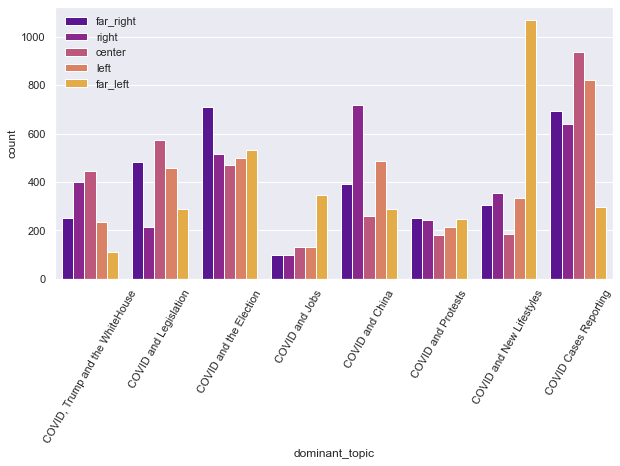

In [155]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='dominant_topic', hue='target',data=data,palette='plasma')
ax.set_xticklabels(['COVID, Trump and the WhiteHouse',
                    'COVID and Legislation',
                   'COVID and the Election',
                   'COVID and Jobs',
                   'COVID and China',
                   'COVID and Protests',
                   'COVID and New Lifestyles',
                   'COVID Cases Reporting'])

ax.legend(loc='upper left', frameon=False)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/topic_by_target.png')

plt.show()

- Not surprising that the Far_Right overwhelmingly accounts for the articles about China.
- Very interesting that both right and far_left have similar counts for topic 3. I wonder how polarity differs here

In [160]:
data.to_csv('clean_data2.csv')

**Run below cell to skip above steps**

In [9]:
data = pd.read_csv('clean_data2.csv',index_col=0)

# EDA

In [10]:
%%time
vectorizer = TfidfVectorizer(max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)
vectorizer.fit(data.predictor)

CPU times: user 3min 15s, sys: 4.59 s, total: 3min 20s
Wall time: 6min 3s


TfidfVectorizer(preprocessor=<function clean_txt at 0x129317c10>, smooth_idf=1,
                strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [11]:
def create_tf_matrix(target):
    return vectorizer.transform(data[data.target == target].predictor)

def create_term_freq(matrix, cat):
    category_words = matrix.sum(axis=0)
    category_words_freq = [(word, category_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    return pd.DataFrame(list(sorted(category_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms', cat])

for cat in ['far_left','left','center','right','far_right']:
    print("Top 10 terms for: ", cat)
    df_right = create_term_freq(create_tf_matrix(cat), cat).head(15)
    print(df_right)
    print("###############")
    if cat != 'far_left':
        df_top20_words = df_top20_words.merge(df_right, how='outer')
    else:
        df_top20_words = df_right.copy()
    
    print(df_top20_words.shape )

Top 10 terms for:  far_left
          Terms   far_left
0        people  73.671432
1   coronavirus  69.149964
2         trump  64.100357
3          also  56.472180
4          even  54.206180
5      pandemic  54.169998
6          take  53.148330
7          work  52.842012
8         covid  52.725730
9         would  52.565366
10         home  50.077257
11         tell  48.752148
12         many  46.797408
13         want  46.496163
14      company  45.690103
###############
(15, 2)
Top 10 terms for:  left
          Terms       left
0   coronavirus  89.796369
1         trump  78.132238
2        people  76.315231
3         state  71.992170
4          test  71.077672
5         covid  71.059503
6          case  70.911495
7        health  70.110964
8         virus  64.834845
9     president  62.919765
10     pandemic  60.640140
11         also  60.597231
12        would  60.001242
13         tell  52.962836
14         take  52.817798
###############
(21, 3)
Top 10 terms for:  center
          

In [12]:
df_top20_words.fillna(0, inplace=True )
df_top20_words.set_index('Terms', inplace=True)
df_top20_words.shape

(31, 5)

In [13]:
import numpy as np
from textacy.viz.termite import draw_termite_plot

In [14]:
df = df_top20_words.copy()
df_norm = (df) / (df.max() - df.min())

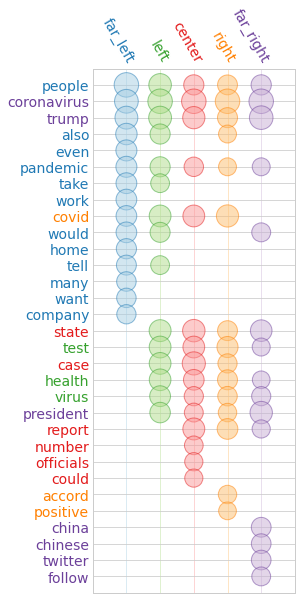

In [15]:
draw_termite_plot(np.array(df_norm.values),df_top20_words.columns,df_top20_words.index,highlight_cols=[0,1,2,3,4])
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/termite_plot.png')

In [34]:
%%time
vectorizer = TfidfVectorizer(max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(2, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)
vectorizer.fit(data.predictor)

CPU times: user 1min 35s, sys: 720 ms, total: 1min 36s
Wall time: 1min 36s


TfidfVectorizer(ngram_range=(2, 2),
                preprocessor=<function clean_txt at 0x1227c3940>, smooth_idf=1,
                strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [35]:
def create_tf_matrix(target):
    return vectorizer.transform(data[data.target == target].predictor)

def create_term_freq(matrix, cat):
    category_words = matrix.sum(axis=0)
    category_words_freq = [(word, category_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    return pd.DataFrame(list(sorted(category_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms', cat])

for cat in ['far_left','left','center','right','far_right']:
    print("Top 10 terms for: ", cat)
    df_right = create_term_freq(create_tf_matrix(cat), cat).head(10)
    print(df_right)
    print("###############")
    if cat != 'far_left':
        df_top20_words = df_top20_words.merge(df_right, how='outer')
    else:
        df_top20_words = df_right.copy()
    
    print(df_top20_words.shape )

Top 10 terms for:  far_left
                  Terms   far_left
0       social distance  16.146413
1  coronavirus pandemic  14.792866
2             last week  11.433811
3         public health  11.332638
4           white house  11.267472
5          donald trump  10.910021
6             stay home   9.256521
7         test positive   8.900853
8  coronavirus outbreak   8.378815
9          social media   8.060742
###############
(10, 2)
Top 10 terms for:  left
                  Terms       left
0           white house  20.627666
1          donald trump  18.907978
2         test positive  17.521254
3      president donald  17.047385
4  coronavirus pandemic  16.822934
5      coronavirus case  14.903958
6         public health  14.770019
7       social distance  12.920973
8             last week  12.857916
9     business insiders  12.585365
###############
(13, 3)
Top 10 terms for:  center
                  Terms     center
0      coronavirus case  23.903025
1         test positive  21.003666

In [36]:
df_top20_words.fillna(0, inplace=True )
df_top20_words.set_index('Terms', inplace=True)
df_top20_words.shape

(29, 5)

In [37]:
df = df_top20_words.copy()
df_norm = (df) / (df.max() - df.min())

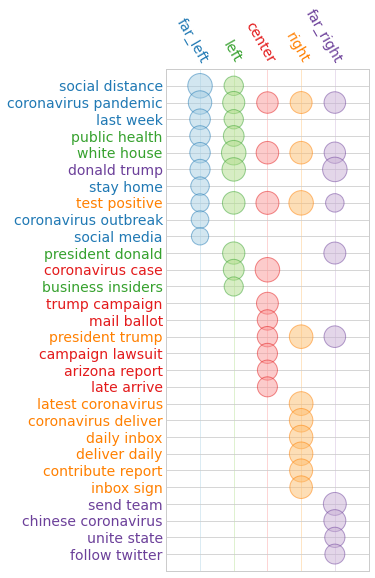

In [38]:
draw_termite_plot(np.array(df_norm.values),df_top20_words.columns,df_top20_words.index,highlight_cols=[0,1,2,3,4])
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/termite_plot2.png')

In [162]:
import re
test = 'latest latest coronavirus'

re.sub("latest coronavirus", "",test)


'latest '

**Polarity by target**

In [68]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

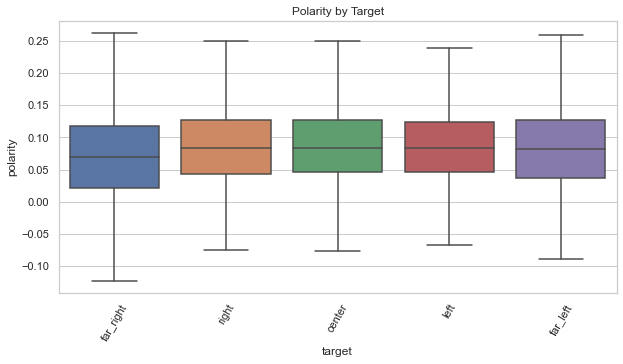

In [77]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="polarity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="polarity", data=data, color=".25")
ax.set_title('Polarity by Target')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/pol_by_target.png')

- Far_Right is slighlty less positive about Coronavirus News overall, but also has the widest variance

**Polarity over time**

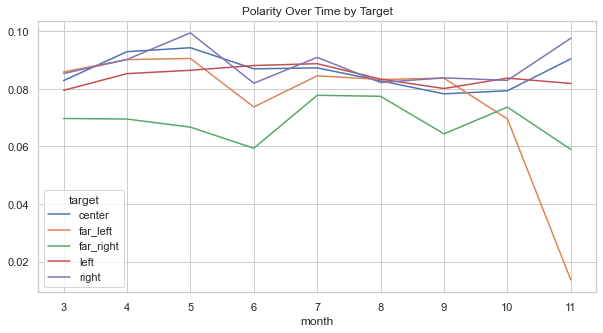

In [76]:
data.groupby(by=['month','target'])['polarity'].mean().unstack().plot(figsize=(10,5))
plt.title('Polarity Over Time by Target')
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/pol_time.png')

- Disregarding month 11 (not enough data) it appears that indeed Far_Right is least positive month over month

**Subjectivity by target**

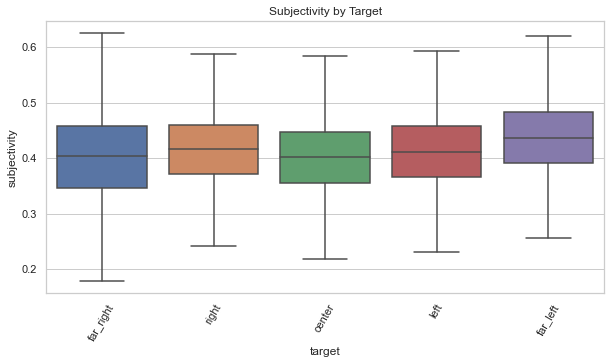

In [78]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="subjectivity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="polarity", data=data, color=".25")
ax.set_title('Subjectivity by Target')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/sub_by_target.png')

**Subjectivity over time**

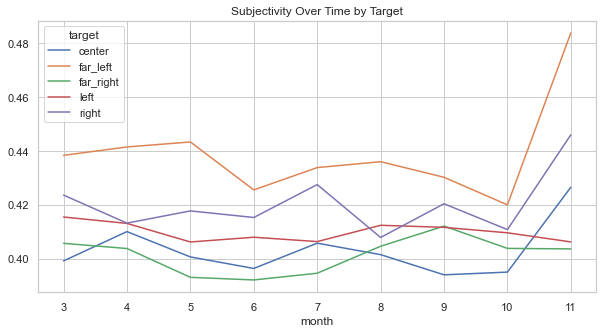

In [80]:
data.groupby(by=['month','target'])['subjectivity'].mean().unstack().plot(figsize=(10,5))
plt.title('Subjectivity Over Time by Target')
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/sub_time.png')

**n_long_words by target**

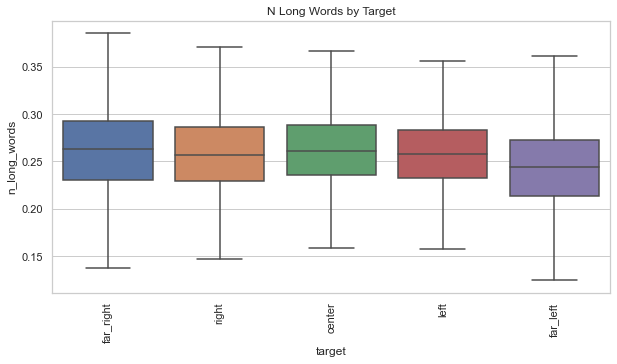

In [81]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_long_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N Long Words by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/longwords_target.png')

**n_monosyllable_words by target**

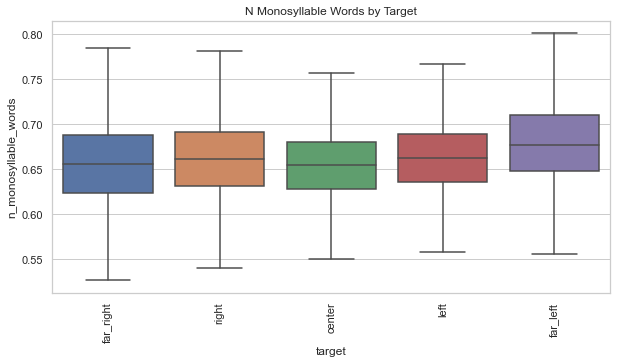

In [82]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_monosyllable_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N Monosyllable Words by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/mono_target.png')

**n_polysyllable_words by target**

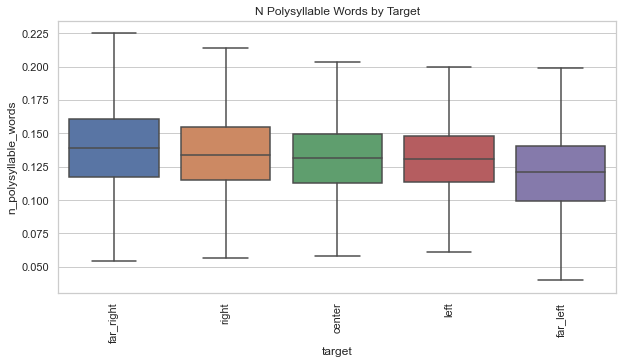

In [83]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_polysyllable_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N Polysyllable Words by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/poly_target.png')

**n_unique_words by target**

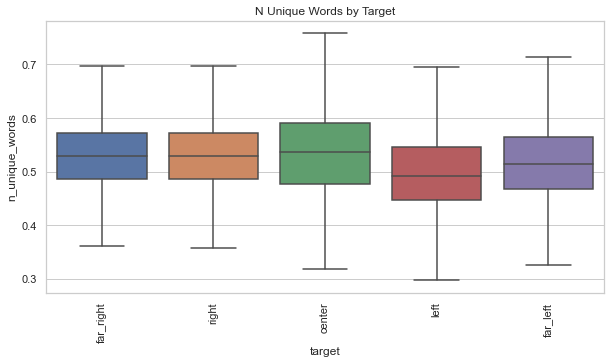

In [84]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_unique_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N Unique Words by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/unique_target.png')

**mccphw by target**

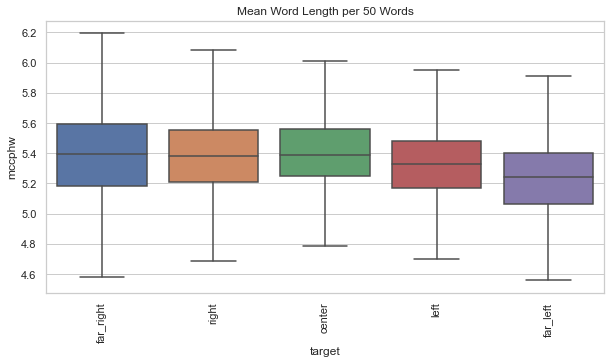

In [85]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="mccphw", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('Mean Word Length per 50 Words')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/mccphw_target.png')


**MSCPHW by target**

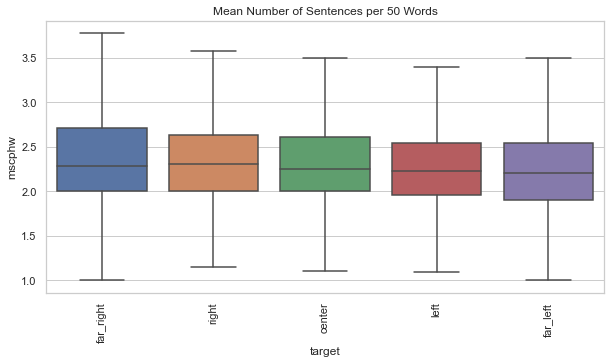

In [86]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="mscphw", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('Mean Number of Sentences per 50 Words')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/mccphw_target.png')


**coleman_index by target**

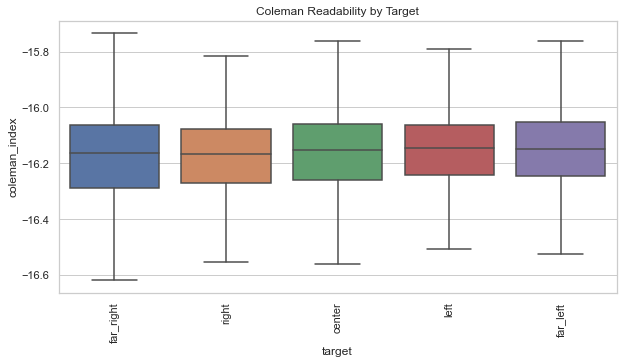

In [87]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="coleman_index", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('Coleman Readability by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/coleman_index.png')


**Profanity**

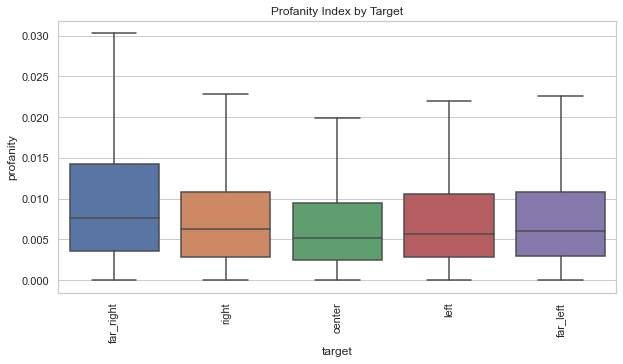

In [88]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="profanity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('Profanity Index by Target')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/coleman_index.png')
